In [1]:
import wandb
import random
import math
wandb.login()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mariemagdalene-spreen (mariemagdalene-spreen-universit-t-osnabr-ck). Use `wandb login --relogin` to force relogin


True

In [2]:
sweep_config = {
    "method": "random"
    }

metric = {
        "name": "val_error",
        "goal": "minimize"
        }

sweep_config["metric"] = metric

parameters_dict = {
        "lr_pi": {
            "min": 0.001,
            "max": 0.01
            },
        "lr_ip": {
            "min": 0.0001,
            "max": 0.001
            },
        "n_samples": {
            "value": 1000
            },
        "noise": {
            "value": 0.3
            },
        "hidden_size": {
            "value": 20
            },
        "actfunc": {
            "value": "softrelu"
            },
        "tau_weights": {
            "min": 1,
            "max": 30
            }
        }   

sweep_config["parameters"] = parameters_dict

In [3]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'val_error'},
 'parameters': {'actfunc': {'value': 'softrelu'},
                'hidden_size': {'value': 20},
                'lr_ip': {'max': 0.001, 'min': 0.0001},
                'lr_pi': {'max': 0.01, 'min': 0.001},
                'n_samples': {'value': 1000},
                'noise': {'value': 0.3},
                'tau_weights': {'max': 30, 'min': 1}}}


In [4]:
sweep_id = wandb.sweep(sweep_config, project="thesis")

Create sweep with ID: yyxvgblu
Sweep URL: https://wandb.ai/mariemagdalene-spreen-universit-t-osnabr-ck/thesis/sweeps/yyxvgblu


In [ ]:
import torch.optim as optim
from training_and_eval import create_dataset, self_pred_training 
from netClasses import *
from tqdm import tqdm
from plotFunctions import *

T = 1000
DT = 0.1
TAU_NEU = 3
BATCH_SIZE = 1
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def hardsigm(x):
    return x.clamp(min=-1).clamp(max=1)

def tanh(x):
    return torch.tanh(x)

def logexp(x):
    return torch.log(0 + torch.exp(x))

def softrelu(x):
    gamma = 0.1
    beta = 1
    theta = 3
    return gamma * torch.log(1 + torch.exp(beta * (x - theta)))


def activation_function(actfunc):
    if actfunc == "logexp":
        return logexp
    elif actfunc == "hardsigm":
        return hardsigm
    elif actfunc == "tanh":
        return tanh
    elif actfunc == "softrelu":
        return softrelu


def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        rho = activation_function(config.actfunc)
        torch.manual_seed(0)
        net = dendriticNet(
            T,
            DT,
            BATCH_SIZE,
            size_tab=[30, 20, 10],
            lr_pp=[0.0011875, 0.0005],
            lr_ip=[config.lr_ip],
            lr_pi=[config.lr_pi],
            ga=0.8,
            gb=1,
            gd=1,
            glk=0.1,
            gsom=0.8,
            noise=0.3,
            tau_weights=config.tau_weights,
            rho=rho,
            initw=1,
        )
        torch.manual_seed(0)
        data = create_dataset(config.n_samples, BATCH_SIZE, 30, 0, 1, DEVICE)  
        net.to(DEVICE)
        net.train()
        with torch.no_grad():
            s, i = net.initHidden(device=DEVICE)
            data_trace = data[0].clone()
            va_topdown_hist=[]
            va_cancelation_hist=[]
            wpf_hist=[]
            wpb_hist=[]
            wpi_hist=[]
            wip_hist=[]
            for n in tqdm(range(data.shape[0])):
                for k in range(T):
                    # low-pass filter the data
                    data_trace += (DT / TAU_NEU) * (-data_trace + data[n])
                    s, i, va = net.stepper(data_trace, s, i, track_va=True)
                    # Track apical potential, neurons and synapses
                    if k == 0 and n % 20 == 0:
                        va_topdown, va_cancelation = va
                        # Update the tabs with the current values
                        va_topdown_hist = net.updateHist(va_topdown_hist, va_topdown)
                        va_cancelation_hist = net.updateHist(
                            va_cancelation_hist, va_cancelation
                        )
                        wpf_hist = net.updateHist(wpf_hist, net.wpf, param=True)
                        wpb_hist = net.updateHist(wpb_hist, net.wpb, param=True)
                        wpi_hist = net.updateHist(wpi_hist, net.wpi, param=True)
                        wip_hist = net.updateHist(wip_hist, net.wip, param=True)

                    # Update the pyramidal-to-interneuron weights (NOT the pyramidal-to-pyramidal weights !)
                    net.updateWeights(
                        data[n], s, i, freeze_feedback=True, selfpredict=True
                    )

                va_topdown, va_cancelation = va
                err = (
                    ((va_topdown[0] + va_cancelation[0]) ** 2)
                    .cpu()
                    .numpy()
                    .mean(1)[0]
                )
                sqrd_frob_norm_wpb_wpi = (torch.norm(net.wpb[0].weight.unsqueeze(2) - net.wpi[0].weight.unsqueeze(2), p="fro", dim=(0, 1)) ** 2)
                sqrd_frob_norm_wpf_wip = (torch.norm(net.wpf[1].weight.unsqueeze(2) - net.wip[0].weight.unsqueeze(2), p="fro", dim=(0, 1)) ** 2)
                wandb.log(
                    {
                        "error": err,
                        "sqrd_frob_norm_wpb_wpi": sqrd_frob_norm_wpb_wpi,
                        "sqrd_frob_norm_wpf_wip": sqrd_frob_norm_wpf_wip
                    }
                )
        # save the weights in a file named after the wandb run
        net.save_weights(wandb.run.name)

        plot_synapse_distance(
            r"learning_selfpred ({}eps): synapse distance".format(n),
            net.net_depth + 1,
            wpf_hist,
            wpb_hist,
            wpi_hist,
            wip_hist,
        )

        plot_synapse_trace(
            r"learning_selfpred ({}eps): synapse trace".format(n),
            net.net_depth + 1,
            wpf_hist,
            wpb_hist,
            wpi_hist,
            wip_hist,
        )
        plot_apical_distance(
            r"learning_selfpred ({}eps): apical distance".format(n),
            net.net_depth + 1,
            va_topdown_hist,
            va_cancelation_hist,
        )

wandb: Agent Starting Run: rcusddgn with config:
wandb: 	actfunc: softrelu
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.0006817904562713748
wandb: 	lr_pi: 0.0023527279320156385
wandb: 	n_samples: 1000
wandb: 	noise: 0.3
wandb: 	tau_weights: 1


100%|██████████| 1000/1000 [15:49<00:00,  1.05it/s]


error,▆█▆▅▅▁▄▃▄▆▄▄▃▃█▅▇▂▄▅▂▃▄▅▃▃▃▆▂▁▄▃▂▁▂▄▄▁▁▂
sample,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇████
sqrd_frob_norm_wpb_wpi,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇███████
sqrd_frob_norm_wpf_wip,▁▁▁▁▁▁█████████████▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁
error,0.0001
sample,999
sqrd_frob_norm_wpb_wpi,135.15508
sqrd_frob_norm_wpf_wip,139.0399


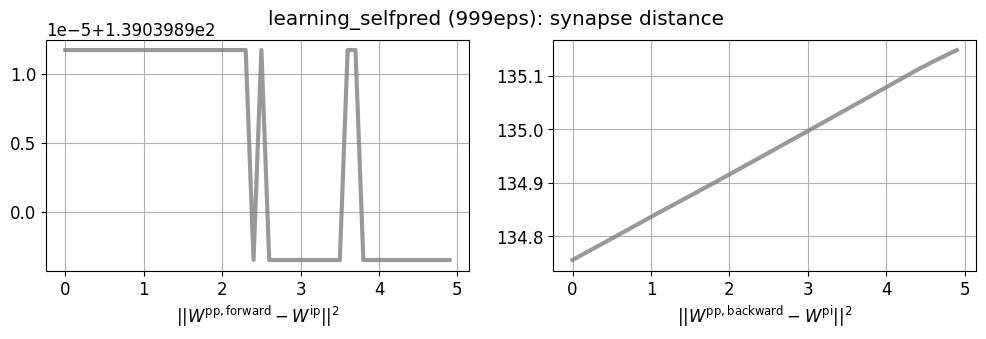

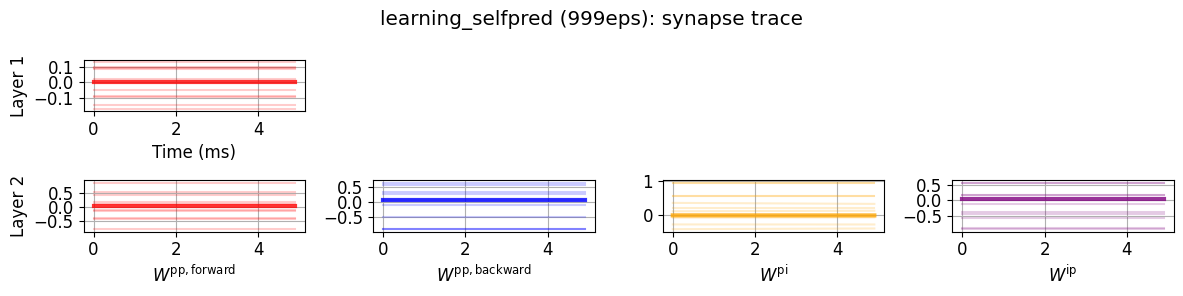

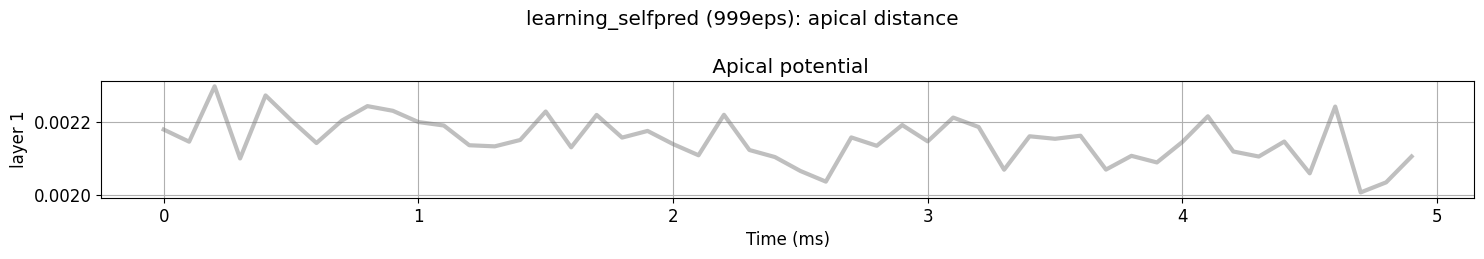

In [6]:
wandb.agent(sweep_id, train, count=1)

In [7]:
train(sweep_config)

Traceback (most recent call last):
  File "/tmp/ipykernel_591821/2037601168.py", line 65, in train
    data = create_dataset(config.n_samples, BATCH_SIZE, 0, 1, DEVICE)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: create_dataset() missing 1 required positional argument: 'device'


TypeError: create_dataset() missing 1 required positional argument: 'device'